<a href="https://colab.research.google.com/github/ppkgtmm/sentiment/blob/GRU/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install keras-tuner
# !rm -r sentiment
# !git clone --branch utils https://github.com/ppkgtmm/sentiment.git sentiment

In [3]:
import pandas as pd
from keras.preprocessing.text import  Tokenizer
from keras.layers import Input, Dense, Embedding, GRU
from keras.models import Sequential
from keras.metrics import Precision, Recall, FalseNegatives, \
FalsePositives, TrueNegatives, TruePositives
from kerastuner import HyperParameters
import matplotlib.pyplot as plt
from sentiment.utils import read_data, get_optimizer, get_sequences, split_data
from sentiment.utils import get_tuner, get_model_from_config, get_callbacks
from sentiment.utils import OH_fit_transform, OH_transform, load, dump, \
model_evaluate

In [4]:
cols = ['text', 'target']
data_path = '/content/drive/MyDrive/sentiment/data/data_preprocessed.csv'
test_path = '/content/drive/MyDrive/sentiment/data/test_data_preprocessed.csv'
seed = 123456
num_words = 10000
max_len = 250
optimizers = [
           'Adam',
           'RMSprop'   
]

In [5]:
data = read_data(data_path,cols)
data.sample(5)

,text,target
294825,just rent it do not be fooled by the commercia...,0
337708,blaze first kinda bored me well its NUMBER whe...,0
355269,top of the a list for female rockers there onl...,1
215014,entertaining jim henson continued genus his pu...,1
303732,good service but i bought this product and it ...,0


In [6]:
test = read_data(test_path, cols)
test.sample(5)

,text,target
3621,interesting but misguided noretta koertge is s...,0
18761,great this is a university report on impotence...,1
10600,sucks one of the worst movies i have ever seen...,0
7430,dissapointedconsumer the chairs are weak and w...,0
17379,it also a study guide the reviewer is right bu...,1


In [7]:
train, val = split_data(data)

In [8]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [9]:
sequence_train = get_sequences(tokenizer, max_len, train['text'])
sequence_val = get_sequences(tokenizer, max_len, val['text'])

In [10]:
print(val['target'].unique(), train['target'].unique())

[1 0] [0 1]


In [11]:
train_target = OH_fit_transform(train['target'])
val_target = OH_transform(val['target'])

In [12]:
def build_gru(hp):
    model = Sequential()
    model.add(Input(shape=(max_len)))
    model.add(
        Embedding(
          num_words, hp.get('output_dim')
        )
    )
    model.add(GRU(hp.get('gru_units')))
    model.add(Dense(2, activation='softmax'))
    model.compile(
        optimizer=get_optimizer(hp.get('optimizer')),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall(),
                 TruePositives(), 
                 TrueNegatives(), 
                 FalsePositives(),
                 FalseNegatives()
              ]
          )
    model.summary()
    return model

In [13]:
hp = HyperParameters()
hp.Int('output_dim', 16, 64, 16)
hp.Choice('gru_units', [2, 8, 16, 32, 64])
hp.Choice('optimizer', optimizers)

'Adam'

In [23]:
tuner = get_tuner(build_gru,'/content/drive/MyDrive/sentiment/GRU',\
                  'GRU_TEMP_B32',hp, 2, 2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 16)           160000    
_________________________________________________________________
gru (GRU)                    (None, 2)                 120       
_________________________________________________________________
dense (Dense)                (None, 2)                 6         
Total params: 160,126
Trainable params: 160,126
Non-trainable params: 0
_________________________________________________________________


## Train

In [24]:
history = tuner.search(
    sequence_train,
    train_target,
    epochs=2,
    validation_data=(sequence_val, val_target),
    batch_size=32,
    use_multiprocessing=True
)

Trial 2 Complete [00h 13m 06s]
val_loss: 0.16196909546852112

Best val_loss So Far: 0.16196909546852112
Total elapsed time: 00h 28m 05s
INFO:tensorflow:Oracle triggered exit


## Refit

In [28]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 64)           640000    
_________________________________________________________________
gru (GRU)                    (None, 64)                24960     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 665,090
Trainable params: 665,090
Non-trainable params: 0
_________________________________________________________________


In [30]:
best_model = get_model_from_config(
    best_model,
    get_optimizer(tuner.get_best_hyperparameters()[0].get('optimizer'))
)

In [31]:
cb = get_callbacks('gru.h5')

In [32]:
history = best_model.fit(
    sequence_train,
    train_target,
    validation_data=(sequence_val, val_target),
    epochs=100,
    callbacks=cb
)

Epoch 1/100
9563/9563 [==============================] - 230s 24ms/step - loss: 0.2859 - accuracy: 0.8729 - precision: 0.8729 - recall: 0.8729 - true_positives: 137284.6644 - true_negatives: 137284.6644 - false_positives: 15755.3264 - false_negatives: 15755.3264 - val_loss: 0.1682 - val_accuracy: 0.9353 - val_precision: 0.9353 - val_recall: 0.9353 - val_true_positives: 50506.0000 - val_true_negatives: 50506.0000 - val_false_positives: 3492.0000 - val_false_negatives: 3492.0000

Epoch 00001: val_loss improved from inf to 0.16817, saving model to gru.h5
Epoch 2/100
9563/9563 [==============================] - 210s 22ms/step - loss: 0.1487 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - true_positives: 144435.0240 - true_negatives: 144435.0240 - false_positives: 8604.9668 - false_negatives: 8604.9668 - val_loss: 0.1580 - val_accuracy: 0.9390 - val_precision: 0.9390 - val_recall: 0.9390 - val_true_positives: 50703.0000 - val_true_negatives: 50703.0000 - val_false_positives: 3295.

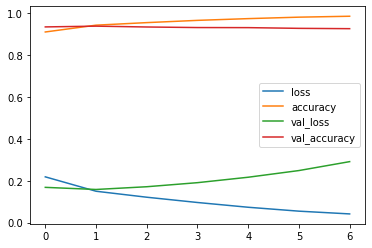

In [34]:
metr = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
pd.DataFrame(history.history)[metr].plot()

In [35]:
# dump(history.history,'/content/drive/MyDrive/sentiment/GRU/GRU_TEMP_B32/history.pickle')
# dump(tokenizer,'/content/drive/MyDrive/sentiment/GRU/GRU_TEMP_B32/tokenizer.pickle')

## Test

In [36]:
sequence_test = get_sequences(tokenizer, max_len, test['text'])
test_target = OH_transform(test['target'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


625/625 [==============================] - 4s 5ms/step
Accuracy:	93.7%


              precision    recall  f1-score   support

           0       0.94      0.93      0.94     10000
           1       0.94      0.94      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



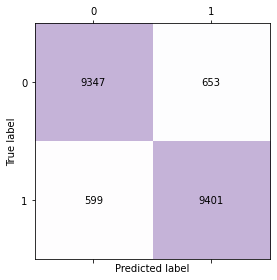

In [37]:
model_evaluate(best_model, sequence_test, test_target, 32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 64)           640000    
_________________________________________________________________
gru (GRU)                    (None, 64)                24960     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 665,090
Trainable params: 665,090
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


625/625 [==============================] - 4s 5ms/step
Accuracy:	93.7%


              precision    recall  f1-score   support

           0       0.93      0.94      0.94     10000
           1       0.94      0.93      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



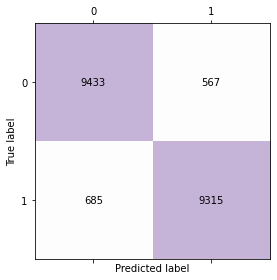

In [38]:
# model that wasn't refitted
model_evaluate(tuner.get_best_models(num_models=1)[0], sequence_test, test_target, 32)

## Insights

In [25]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/sentiment/GRU/GRU_TEMP_B32
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
output_dim: 64
gru_units: 64
optimizer: Adam
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.16196909546852112
Trial summary
Hyperparameters:
output_dim: 64
gru_units: 8
optimizer: Adam
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.17348305135965347
